## TOKEN EMBEDDINGS


![Screenshot](images/screenshot1.png)


a well trained embedding can capture significant syntactical information

<div class="alert alert-block alert-success">
    
Let's illustrate how the token ID to embedding vector conversion works with a hands-on
example. Suppose we have the following four input tokens with IDs 2, 3, 5, and 1:</div>

In [1]:
import torch
input_ids = torch.tensor([1, 2, 3, 4, 5])

<div class="alert alert-block alert-success">
    
For the sake of simplicity and illustration purposes, suppose we have a small vocabulary of
only 6 words (instead of the 50,257 words in the BPE tokenizer vocabulary), and we want
to create embeddings of size 3 (in GPT-3, the embedding size is 12,288 dimensions):

</div>

<div class="alert alert-block alert-success">
    
Using the vocab_size and output_dim, we can instantiate an embedding layer in PyTorch,
setting the random seed to 123 for reproducibility purposes:

</div>

In [2]:
vocab_size = 6
output_dim = 4
torch.manual_seed(123)
embedding_layer = torch.nn.Embedding(vocab_size,output_dim)

In [3]:
embedding_layer.weight

Parameter containing:
tensor([[ 0.3374, -0.1778, -0.3035, -0.5880],
        [ 0.3486,  0.6603, -0.2196, -0.3792],
        [-0.1606, -0.4015,  0.6957, -1.8061],
        [ 1.8960, -0.1750,  1.3689, -1.6033],
        [-0.7849, -1.4096, -0.4076,  0.7953],
        [ 0.9985,  0.2212,  1.8319, -0.3378]], requires_grad=True)

<div class="alert alert-block alert-info">
    
We can see that the weight matrix of the embedding layer contains small, random values.
These values are optimized during LLM training as part of the LLM optimization itself, as we
will see in upcoming chapters. Moreover, we can see that the weight matrix has six rows
and three columns. There is one row for each of the six possible tokens in the vocabulary.
And there is one column for each of the three embedding dimensions.
    
</div>

<div class="alert alert-block alert-success">
    
After we instantiated the embedding layer, let's now apply it to a token ID to obtain the
embedding vector:

</div>

In [4]:
embedding_layer(torch.tensor([3])) # 4ht row of the matrix

tensor([[ 1.8960, -0.1750,  1.3689, -1.6033]], grad_fn=<EmbeddingBackward0>)



<div class="alert alert-block alert-info">
    
each row in the embedding matrix is just an lookup to the token ids
    
</div>

In [5]:
torch.tensor([3])

tensor([3])

![Screenshot](images/screenshot4.png)



this is after sinosuindal encoding, pick and 2 words which are close you'll see that most of the vector is same and for any two vectroo far away from each other the vectors are differnt , thus this is captuirinmg the relative positions pretty good, also if you see absolute positions of words are also captures in this as first word and last word are quite different (pick a line horizontally it represents positional encoding vector)

![Screenshot](images/screenshot5.png)




**POSITIONAL EMBEDDINGS (ENCODING WORD POSITIONS)**

In [6]:
from torch.utils.data import Dataset, DataLoader
import torch
import tiktoken
import re

In [7]:
from torch.utils.data import Dataset, DataLoader
import torch
class GPTDatasetV1(Dataset):
    def __init__(self, txt, tokenizer, max_length, stride):
        self.input_ids = []
        self.target_ids = []

        token_ids = tokenizer.encode(txt, allowed_special={"<|endoftext|>"})

        #using sliding window to ceate input and target pairs
        for i in range(0, len(token_ids) - max_length, stride):
            input_chunk = token_ids[i: i + max_length]
            target_chunk = token_ids[i+1: max_length + 1 + i]
            self.input_ids.append(torch.tensor(input_chunk))
            self.target_ids.append(torch.tensor(target_chunk))

    def __len__(self):
        return len(self.input_ids)
    
    def __getitem__(self, idx):

        return self.input_ids[idx], self.target_ids[idx]

In [8]:
class SimpleTokenizerV2:
    def __init__(self,vocab):
        self.str_to_int = vocab
        self.int_to_str = {i:s for s,i in vocab.items()}

    def encode(self, text):
        pre_processed = re.split(r'([,.:;"!?()\'_]|--|\s)', text)   
        pre_processed = [item for item in pre_processed if item.strip()]
        pre_processed = [item if item in self.str_to_int else "<|unk|>" for item in pre_processed]

        ids = [self.str_to_int[s] for s in pre_processed]
        return ids
    
    def decode(self, ids):
        text = " ".join([self.int_to_str[i] for i in ids])
        text = re.sub(r'\s+([,.?!"()\'])', r'\1', text)
        return text


In [9]:
def create_dataloader_v1(txt, batch_size=4, max_length=256, 
                         stride=128, shuffle=True, drop_last=True,
                         num_workers=0):

    # Initialize the tokenizer
    tokenizer = tiktoken.get_encoding("gpt2")

    # Create dataset
    dataset = GPTDatasetV1(txt, tokenizer, max_length, stride)

    # Create dataloader
    dataloader = DataLoader(
        dataset,
        batch_size=batch_size,
        shuffle=shuffle,
        drop_last=drop_last,
        num_workers=num_workers
    )

    return dataloader

In [10]:
import torch
vocab_size = 50257
output_dim = 256

token_embedding_layer = torch.nn.Embedding(vocab_size,output_dim)

In [11]:
with open("wharton_verdict.txt", "r", encoding = "utf-8") as f:
    raw_text = f.read()

In [12]:
max_length = 4
dataloader = create_dataloader_v1(raw_text, batch_size = 8,
                                  max_length = max_length, stride = 2,
                                  shuffle = True)

data_iter = iter(dataloader)
inputs, targets  = next(data_iter)

In [13]:
print("Token IDs:\n", inputs)
print("\nInputs shape:\n", inputs.shape)

Token IDs:
 tensor([[  257,  1207,  8344,   803],
        [  625,   262, 24818,   417],
        [  257,  6487,    13,   366],
        [  198,  1544, 13818,  4622],
        [35569,   502,    13,   887],
        [  683,    11, 10597,   314],
        [  198,  1870,   465,  8216],
        [  198,   265,  6384,  1456]])

Inputs shape:
 torch.Size([8, 4])


In [14]:
token_embeddings = token_embedding_layer(inputs)
print("\nToken Embeddings:\n", token_embeddings.shape)


Token Embeddings:
 torch.Size([8, 4, 256])


In [15]:
context_length = max_length
pos_embedding_layer = torch.nn.Embedding(context_length, output_dim)

In [16]:
pos_embeddings = pos_embedding_layer(torch.arange(max_length))
print(pos_embeddings.shape)

torch.Size([4, 256])


In [17]:
input_embeddings = token_embeddings + pos_embeddings
print(input_embeddings.shape)

torch.Size([8, 4, 256])


<div class="alert alert-block alert-info">
    
As shown in the preceding code example, the input to the pos_embeddings is usually a
placeholder vector torch.arange(context_length), which contains a sequence of
numbers 0, 1, ..., up to the maximum input length − 1. 

The context_length is a variable
that represents the supported input size of the LLM. 

Here, we choose it similar to the
maximum length of the input text. 

In practice, input text can be longer than the supported
context length, in which case we have to truncate the text.
    
</div>

<div class="alert alert-block alert-info">
    
As we can see, the positional embedding tensor consists of four 256-dimensional vectors.
We can now add these directly to the token embeddings, where PyTorch will add the 4x256-
dimensional pos_embeddings tensor to each 4x256-dimensional token embedding tensor in
each of the 8 batches:
    
</div>

In [18]:
input_embeddings.shape

torch.Size([8, 4, 256])

## IMPLEMENTING A COMPACT SELF ATTENTION PYTHON CLASS

In [19]:
import torch.nn as nn
import torch

class SelfAttention_v1(nn.Module):

    def __init__(self, d_in, d_out):
        super().__init__()
        self.W_Q = nn.Parameter(torch.randn(d_in, d_out))
        self.W_K = nn.Parameter(torch.randn(d_in, d_out))
        self.W_V = nn.Parameter(torch.randn(d_in, d_out))

    def forward(self, x):
        keys = x @ self.W_K
        queries = x @ self.W_Q
        values = x @ self.W_V

        attn_scores = queries @ keys.T
        attn_weights = torch.softmax(attn_scores / keys.shape[-1]**0.5 , dim=-1)
        context_vec = attn_weights @ values
        return context_vec

In [20]:
inputs = torch.tensor(
  [[0.43, 0.15, 0.89], # Your     (x^1)
   [0.55, 0.87, 0.66], # journey  (x^2)
   [0.57, 0.85, 0.64], # starts   (x^3)
   [0.22, 0.58, 0.33], # with     (x^4)
   [0.77, 0.25, 0.10], # one      (x^5)
   [0.05, 0.80, 0.55]] # step     (x^6)
)

torch.manual_seed(123) 

sa_v1 = SelfAttention_v1(3,5)
print(sa_v1(inputs))

tensor([[ 0.7053, -0.5213,  0.7561, -1.1033,  0.0726],
        [ 0.6443, -0.5202,  0.7027, -1.0369,  0.1176],
        [ 0.6507, -0.5203,  0.7091, -1.0447,  0.1130],
        [ 0.6933, -0.5269,  0.7448, -1.0918,  0.0881],
        [ 0.7910, -0.5222,  0.8522, -1.2159,  0.0105],
        [ 0.6292, -0.5259,  0.6801, -1.0142,  0.1349]], grad_fn=<MmBackward0>)


In [21]:
import torch.nn as nn

class SelfAttention_v2(nn.Module):

    def __init__(self, d_in, d_out):
        super().__init__()
        self.W_Q = nn.Linear(d_in, d_out, bias=False)
        self.W_K = nn.Linear(d_in, d_out, bias=False)
        self.W_V = nn.Linear(d_in, d_out, bias=False)

    def forward(self, x):
        keys = self.W_K(x)
        queries = self.W_Q(x)
        values = self.W_V(x)

        attn_scores = queries @ keys.T
        attn_weights = torch.softmax(attn_scores / keys.shape[-1]**0.5 , dim=-1)
        context_vec = attn_weights @ values
        return context_vec

In [22]:
torch.manual_seed(789)
sa_v1 = SelfAttention_v2(3,2)
print(sa_v1(inputs))

tensor([[-0.0739,  0.0713],
        [-0.0748,  0.0703],
        [-0.0749,  0.0702],
        [-0.0760,  0.0685],
        [-0.0763,  0.0679],
        [-0.0754,  0.0693]], grad_fn=<MmBackward0>)


## HIDING FUTURE WORDS WITH CAUSAL ATTENTION

In [23]:
context_length = inputs.shape[0]
torch.triu(torch.ones(context_length, context_length))

tensor([[1., 1., 1., 1., 1., 1.],
        [0., 1., 1., 1., 1., 1.],
        [0., 0., 1., 1., 1., 1.],
        [0., 0., 0., 1., 1., 1.],
        [0., 0., 0., 0., 1., 1.],
        [0., 0., 0., 0., 0., 1.]])

### IMPLEMENTING A COMPACT CAUSAL ATTENTION CLASS

<div class="alert alert-block alert-success">

In this section, we will now incorporate the causal attention and dropout modifications into
the SelfAttention Python class we developed in section 3.4. 

This class will then serve as a
template for developing multi-head attention in the upcoming section.

</div>

<div class="alert alert-block alert-success">

Before we begin, one more thing is to ensure that the code can handle batches
consisting of more than one input. 

This will ensure that the CausalAttention class supports the batch
outputs produced by the data loader we implemented earlier.

</div>

<div class="alert alert-block alert-success">

For simplicity, to simulate such batch inputs, we duplicate the input text example:

</div>

<div class="alert alert-block alert-info">

 2 inputs with 6 tokens each, and each token has embedding dimension 3
    
</div>

In [24]:
inputs = torch.tensor(
  [[0.43, 0.15, 0.89], # Your     (x^1)
   [0.55, 0.87, 0.66], # journey  (x^2)
   [0.57, 0.85, 0.64], # starts   (x^3)
   [0.22, 0.58, 0.33], # with     (x^4)
   [0.77, 0.25, 0.10], # one      (x^5)
   [0.05, 0.80, 0.55]] # step     (x^6)
                )
batch = torch.stack((inputs, inputs), dim=0)
print(batch.shape) 



torch.Size([2, 6, 3])


In [25]:
class CasualAttention(nn.Module):

    def __init__(self, d_in, d_out, context_length, dropout, qkv_bias=False):
        super().__init__()
        self.d_out = d_out
        self.W_query = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_key   = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_value = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.dropout = nn.Dropout(dropout)
        self.register_buffer('mask', torch.triu(torch.ones(context_length,context_length),diagonal = 1))

    def forward(self, x):
        b, num_tokens , d_in = x.shape
        keys = self.W_key(x)
        queries = self.W_query(x)
        values = self.W_value(x)

        attn_scores = queries @ keys.transpose(1,2)
        attn_scores.masked_fill_(self.mask.bool()[:num_tokens, :num_tokens], -torch.inf) 
        attn_weights = torch.softmax(attn_scores /keys.shape[-1]**0.5, dim = 1)
        attn_weights = self.dropout(attn_weights)
        context_vec = attn_weights @ values
        return context_vec


In [26]:
torch.manual_seed(123)
context_length = batch.shape[1]
ca = CasualAttention(3, 3, context_length, dropout=0.5)
context_vec = ca(batch)
context_vec

tensor([[[ 0.0000,  0.0000,  0.0000],
         [ 0.1081,  0.1840, -0.1018],
         [ 0.1729,  0.2798, -0.0797],
         [ 0.2621,  0.4295, -0.1738],
         [ 0.3809,  0.5929, -0.1858],
         [ 0.4447,  0.7247, -0.2576]],

        [[ 0.0997,  0.1696, -0.0939],
         [ 0.0000,  0.0000,  0.0000],
         [ 0.2518,  0.4119, -0.1638],
         [ 0.2621,  0.4295, -0.1738],
         [ 0.0951,  0.3614, -0.2786],
         [ 0.4420,  0.6948, -0.2183]]], grad_fn=<UnsafeViewBackward0>)

## EXTENDING SINGLE HEAD ATTENTION TO STACKED ATTENTION (MULTIHEAD ATTENTION)

In [27]:
import torch
import torch.nn as nn

In [28]:
class MultiHeadAtttentionWrapper(nn.Module):
    def __init__(self, d_in, d_out, context_length,dropout, num_heads, qkv_bias = False):
        super().__init__()
        self.heads = nn.ModuleList([
            CasualAttention(d_in, d_out, context_length, dropout, qkv_bias) 
            for _ in range(num_heads)
        ])
    def forward(self, x):
        return torch.cat([head(x) for head in self.heads], dim = -1)

In [29]:
torch.manual_seed(123)
context_length = batch.shape[1]
mha = MultiHeadAtttentionWrapper(3, 3, context_length, dropout=0, num_heads = 2)
context_vec = mha(batch)
context_vec

tensor([[[ 0.0499,  0.0848, -0.0469,  0.0143,  0.0871,  0.0520],
         [ 0.1262,  0.2064, -0.0820,  0.0101,  0.2142,  0.1086],
         [ 0.2124,  0.3458, -0.1218,  0.0081,  0.3906,  0.1888],
         [ 0.2885,  0.4546, -0.1387,  0.0028,  0.5420,  0.2603],
         [ 0.2615,  0.5105, -0.2161,  0.0027,  0.7399,  0.3124],
         [ 0.6519,  0.9957, -0.2431, -0.0180,  1.2439,  0.5864]],

        [[ 0.0499,  0.0848, -0.0469,  0.0143,  0.0871,  0.0520],
         [ 0.1262,  0.2064, -0.0820,  0.0101,  0.2142,  0.1086],
         [ 0.2124,  0.3458, -0.1218,  0.0081,  0.3906,  0.1888],
         [ 0.2885,  0.4546, -0.1387,  0.0028,  0.5420,  0.2603],
         [ 0.2615,  0.5105, -0.2161,  0.0027,  0.7399,  0.3124],
         [ 0.6519,  0.9957, -0.2431, -0.0180,  1.2439,  0.5864]]],
       grad_fn=<CatBackward0>)

### BATCHED STACKED MULTI HEADED ATTENTION

In [30]:
import torch.nn as nn
import torch 
class MultiHeadedAttention(nn.Module):
    def __init__(self, d_in, d_out, context_length, dropout, num_heads, qkv_bias = False):
        super().__init__()
        assert (d_out % num_heads == 0) , "d_out must be divisible by num_heads"

        self.d_out = d_out
        self.num_heads = num_heads
        self.head_dim = d_out // num_heads

        self.W_query = nn.Linear(d_in, d_out, bias = qkv_bias)
        self.W_key = nn.Linear(d_in, d_out, bias = qkv_bias)
        self.W_Value = nn.Linear(d_in, d_out, bias = qkv_bias)
        self.out_proj = nn.Linear(d_out, d_out) # same as W_O
        self.dropout = nn.Dropout(dropout)
        self.register_buffer("mask", torch.triu(torch.ones(context_length, context_length), diagonal=1))

    def forward(self, x):
        b, num_tokens , d_in = x.shape

        keys = self.W_key(x)
        queries = self.W_query(x)
        values = self.W_Value(x)

        keys = keys.view(b, num_tokens, self.num_heads, self.head_dim)
        values = values.view(b, num_tokens, self.num_heads, self.head_dim)
        queries = queries.view(b, num_tokens, self.num_heads, self.head_dim)

        keys = keys.transpose(1,2)
        queries = queries.transpose(1,2)
        values = values.transpose(1,2)

        attn_scores = queries @ keys.transpose(2,3)

        mask_bool = self.mask.bool()[:num_tokens, :num_tokens]

        attn_scores.masked_fill_(mask_bool, -torch.inf)
        attn_weights = torch.softmax(attn_scores / keys.shape[-1]**0.5, dim = -1)
        attn_weights = self.dropout(attn_weights)
        
        context_vec = (attn_weights @ values).transpose(1,2)

        context_vec = context_vec.contiguous().view(b, num_tokens, self.d_out)
        context_vec = self.out_proj(context_vec)

        return context_vec


![Screenshot](images/screenshot6.jpg)


In [31]:
torch.manual_seed(123)

# Define the tensor with 3 rows and 6 columns
inputs = torch.tensor(
    [[0.43, 0.15, 0.89, 0.55, 0.87, 0.66],  # Row 1
     [0.57, 0.85, 0.64, 0.22, 0.58, 0.33],  # Row 2
     [0.77, 0.25, 0.10, 0.05, 0.80, 0.55]]  # Row 3
)

batch = torch.stack((inputs, inputs), dim=0)
print(batch.shape) 

batch_size, context_length, d_in = batch.shape
d_out = 6
mha = MultiHeadedAttention(d_in, d_out, context_length, 0.0, num_heads=2)
context_vecs = mha(batch)
print(context_vecs)
print("context_vecs.shape:", context_vecs.shape)

torch.Size([2, 3, 6])
tensor([[[ 0.1569, -0.0873,  0.0210,  0.0215, -0.3243, -0.2518],
         [ 0.1117, -0.0547,  0.0406, -0.0213, -0.3251, -0.2993],
         [ 0.1196, -0.0491,  0.0318, -0.0635, -0.2788, -0.2578]],

        [[ 0.1569, -0.0873,  0.0210,  0.0215, -0.3243, -0.2518],
         [ 0.1117, -0.0547,  0.0406, -0.0213, -0.3251, -0.2993],
         [ 0.1196, -0.0491,  0.0318, -0.0635, -0.2788, -0.2578]]],
       grad_fn=<ViewBackward0>)
context_vecs.shape: torch.Size([2, 3, 6])


<div class="alert alert-block alert-warning">

For comparison, the smallest GPT-2 model (117 million parameters) has 12 attention
heads and a context vector embedding size of 768. 

The largest GPT-2 model (1.5 billion
parameters) has 25 attention heads and a context vector embedding size of 1600.

Note
that the embedding sizes of the token inputs and context embeddings are the same in GPT
models (d_in = d_out).

</div>

## GPT ARCHITECTURE PART 1: DUMMY GPT MODEL CLASS


<div class="alert alert-block alert-info">

Step 1: Use a placeholder for TransformerBlock

Step 2: Use a placeholder for LayerNorm
</div>

In [32]:
GPT_CONFIG_124M = {
    "vocab_size": 50257,    # Vocabulary size
    "context_length": 1024, # Context length
    "emb_dim": 768,         # Embedding dimension
    "n_heads": 12,          # Number of attention heads
    "n_layers": 12,         # Number of layers
    "drop_rate": 0.1,       # Dropout rate
    "qkv_bias": False       # Query-Key-Value bias
}

In [33]:
cfg = GPT_CONFIG_124M

In [34]:
import torch
import torch.nn as nn

class DummyGPTModel(nn.Module):
    def __init__(self, cfg):
        super().__init__()

        self.tok_emb = nn.Embedding(cfg["vocab_size"], cfg["emb_dim"])
        self.pos_emb = nn.Embedding(cfg["context_length"], cfg["emb_dim"])
        self.dropout = nn.Dropout(cfg["drop_rate"])

        # Use a placeholder for TransformerBlock
        self.trf_blocks = nn.Sequential(
            *[DummyTransformerBlock(cfg) for _ in range(cfg["n_layers"])]
        )
        self.final_norm = DummyLayerNorm(cfg["emb_dim"])
        self.out_head = nn.Linear(cfg["emb_dim"], cfg["vocab_size"], bias=False)
    
    def forward(self, in_idx):
        batch_size, seq_len = in_idx.shape
        tok_embeds = self.tok_emb(in_idx)
        pos_embeds = self.pos_emb(torch.arange(seq_len, device=in_idx.device))
        x = tok_embeds + pos_embeds
        x = self.dropout(x)
        x = self.trf_blocks(x)
        x = self.final_norm(x)
        logits = self.out_head(x)
        return logits


class DummyTransformerBlock(nn.Module):
    def __init__(self, cfg): 
        super().__init__()
        # A simple placeholder

    def forward(self, x):
        # This block does nothing and just returns its input.
        return x


class DummyLayerNorm(nn.Module):
    def __init__(self, normalized_shape, eps=1e-5):
        super().__init__()
        # The parameters here are just to mimic the LayerNorm interface.

    def forward(self, x):
        # This layer does nothing and just returns its input.
        return x

In [35]:
import tiktoken
tokenizer = tiktoken.get_encoding("gpt2")
batch = []
txt1 = "Every effort moves you"
txt2 = "Every day holds a"
batch.append(torch.tensor(tokenizer.encode(txt1)))
batch.append(torch.tensor(tokenizer.encode(txt2)))
batch = torch.stack(batch, dim=0)
print(batch)

tensor([[6109, 3626, 6100,  345],
        [6109, 1110, 6622,  257]])


In [36]:
torch.manual_seed(123)
model = DummyGPTModel(GPT_CONFIG_124M)
logits = model(batch)
print("Output shape:", logits.shape)
print(logits)

Output shape: torch.Size([2, 4, 50257])
tensor([[[-1.2034,  0.3201, -0.7130,  ..., -1.5548, -0.2390, -0.4667],
         [-0.1192,  0.4539, -0.4432,  ...,  0.2392,  1.3469,  1.2430],
         [ 0.5307,  1.6720, -0.4695,  ...,  1.1966,  0.0111,  0.5835],
         [ 0.0139,  1.6754, -0.3388,  ...,  1.1586, -0.0435, -1.0400]],

        [[-1.0908,  0.1798, -0.9484,  ..., -1.6047,  0.2439, -0.4530],
         [-0.7860,  0.5581, -0.0610,  ...,  0.4835, -0.0077,  1.6621],
         [ 0.3567,  1.2698, -0.6398,  ..., -0.0162, -0.1296,  0.3717],
         [-0.2407, -0.7349, -0.5102,  ...,  2.0057, -0.3694,  0.1814]]],
       grad_fn=<UnsafeViewBackward0>)


## LAYER NORMALIZATION

In [37]:
torch.manual_seed(123)
batch_example = torch.randn(2, 5)
layer = nn.Sequential(nn.Linear(5,6), nn.ReLU())
out = layer(batch_example)
print(out)

tensor([[0.2260, 0.3470, 0.0000, 0.2216, 0.0000, 0.0000],
        [0.2133, 0.2394, 0.0000, 0.5198, 0.3297, 0.0000]],
       grad_fn=<ReluBackward0>)


<div class="alert alert-block alert-info">

The neural network layer we have coded consists of a Linear layer followed by a non-linear
activation function, ReLU (short for Rectified Linear Unit), which is a standard activation
function in neural networks. 

If you are unfamiliar with ReLU, it simply thresholds negative
inputs to 0, ensuring that a layer outputs only positive values, which explains why the
resulting layer output does not contain any negative values. 

(Note that we will use another,
more sophisticated activation function in GPT, which we will introduce in the next section).
</div>

In [38]:
mean = out.mean(dim=-1, keepdim = True)
var = out.var(dim=-1, keepdim=True)
print(mean)
print(var)

tensor([[0.1324],
        [0.2170]], grad_fn=<MeanBackward1>)
tensor([[0.0231],
        [0.0398]], grad_fn=<VarBackward0>)


<div class="alert alert-block alert-warning">

The first row in the mean tensor above contains the mean value for the first input row, and
the second output row contains the mean for the second input row.
</div>

In [39]:
out_norm = (out - mean) / torch.sqrt(var)
mean = out_norm.mean(dim = -1, keepdim = True)
var = out_norm.var(dim = -1, keepdim = True)
print("Normalized layer output\n", out_norm)
print("Mean:\n", mean)
print("Variance:\n", var)

Normalized layer output
 tensor([[ 0.6159,  1.4126, -0.8719,  0.5872, -0.8719, -0.8719],
        [-0.0189,  0.1121, -1.0876,  1.5173,  0.5647, -1.0876]],
       grad_fn=<DivBackward0>)
Mean:
 tensor([[-5.9605e-08],
        [ 1.9868e-08]], grad_fn=<MeanBackward1>)
Variance:
 tensor([[1.0000],
        [1.0000]], grad_fn=<VarBackward0>)


<div class="alert alert-block alert-info">

Note that the value 2.9802e-08 in the output tensor is the scientific notation for 2.9802 ×
10-8, which is 0.0000000298 in decimal form. This value is very close to 0, but it is not
exactly 0 due to small numerical errors that can accumulate because of the finite precision
with which computers represent numbers.
</div>

In [40]:
class LayerNorm(nn.Module):
    def __init__(self,emb_dim):
        super().__init__()
        self.eps = 1e-5
        self.scale = nn.Parameter(torch.ones(emb_dim))
        self.shift = nn.Parameter(torch.zeros(emb_dim))

    def forward(self, x):
        mean = x.mean(dim = -1, keepdim = True)
        var = x.var(dim = -1, keepdim = True, unbiased = False)
        norm_x = (x-mean) / torch.sqrt(var + self.eps)
        return self.scale * norm_x + self.shift

<div class="alert alert-block alert-warning">

This specific implementation of layer Normalization operates on the last dimension of the
input tensor x, which represents the embedding dimension (emb_dim). 

The variable eps is a
small constant (epsilon) added to the variance to prevent division by zero during
normalization. 

The scale and shift are two trainable parameters (of the same dimension
as the input) that the LLM automatically adjusts during training if it is determined that
doing so would improve the model's performance on its training task. 

This allows the model
to learn appropriate scaling and shifting that best suit the data it is processing.

</div>

<div class="alert alert-block alert-info">

In our variance calculation method, we have opted for an implementation detail by
setting unbiased=False. 

For those curious about what this means, in the variance
calculation, we divide by the number of inputs n in the variance formula. 

This approach does not apply Bessel's correction, which typically uses n-1 instead of n in
the denominator to adjust for bias in sample variance estimation. 

This decision results in a so-called biased estimate of the variance. 

For large-scale language
models (LLMs), where the embedding dimension n is significantly large, the
difference between using n and n-1 is practically negligible. 

We chose this approach to ensure compatibility with the GPT-2 model's normalization layers and because it
reflects TensorFlow's default behavior, which was used to implement the original GPT2 model.
</div>

In [41]:
ln = LayerNorm(emb_dim = 5)
out_ln  = ln(batch_example)
print(out_ln)
mean = out_ln.mean(dim=-1, keepdim=True)
var = out_ln.var(dim=-1, unbiased=False, keepdim=True)
print("Mean:\n", mean)
print("Variance:\n", var)

tensor([[ 0.5528,  1.0693, -0.0223,  0.2656, -1.8654],
        [ 0.9087, -1.3767, -0.9564,  1.1304,  0.2940]], grad_fn=<AddBackward0>)
Mean:
 tensor([[-2.9802e-08],
        [ 0.0000e+00]], grad_fn=<MeanBackward1>)
Variance:
 tensor([[1.0000],
        [1.0000]], grad_fn=<VarBackward0>)


In [42]:
class GELU(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x):
        return 0.5 * x * (1 + torch.tanh(
            torch.sqrt(torch.tensor(2.0 / torch.pi)) * 
            (x + 0.044715 * torch.pow(x, 3))
        ))

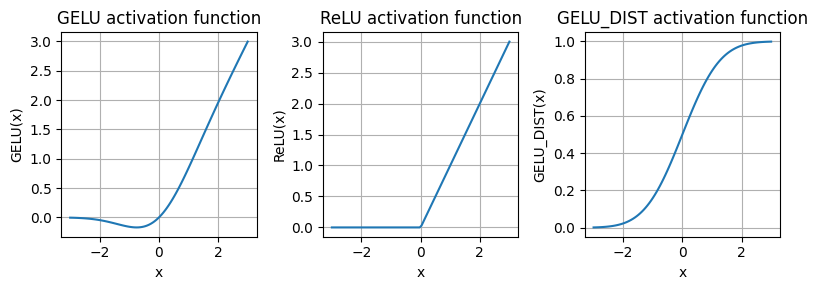

In [43]:
import matplotlib.pyplot as plt

gelu, relu = GELU(), nn.ReLU()

# Some sample data
x = torch.linspace(-3, 3, 100)
y_gelu, y_relu, y_gelu_dist = gelu(x), relu(x), (gelu(x))/x

plt.figure(figsize=(8, 3))
for i, (y, label) in enumerate(zip([y_gelu, y_relu,y_gelu_dist], ["GELU", "ReLU", "GELU_DIST"]), 1):
    plt.subplot(1, 3, i)
    plt.plot(x, y)
    plt.title(f"{label} activation function")
    plt.xlabel("x")
    plt.ylabel(f"{label}(x)")
    plt.grid(True)

plt.tight_layout()
plt.show()


In [44]:
class FeedForward(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(cfg["emb_dim"], 4 * cfg["emb_dim"]),
            GELU(),
            nn.Linear(4 * cfg["emb_dim"], cfg["emb_dim"]),    
        )
    def forward(self, x):
        return self.layers(x)
    

In [45]:
ffn = FeedForward(GPT_CONFIG_124M)
x = torch.rand(2, 3, 768) #A
out = ffn(x)
print(out.shape)

torch.Size([2, 3, 768])


# SHORTCUT CONNECTIONS

![Screenshot](images/screenshot7.png)


In [46]:
class ExampleDeepNeuralNetwork(nn.Module):
    def __init__(self, layer_sizes, use_shortcut):
        super().__init__()
        self.use_shortcut = use_shortcut
        self.layers = nn.ModuleList([
            nn.Sequential(nn.Linear(layer_sizes[0], layer_sizes[1]), GELU()),
            nn.Sequential(nn.Linear(layer_sizes[1], layer_sizes[2]), GELU()),
            nn.Sequential(nn.Linear(layer_sizes[2], layer_sizes[3]), GELU()),
            nn.Sequential(nn.Linear(layer_sizes[3], layer_sizes[4]), GELU()),
            nn.Sequential(nn.Linear(layer_sizes[4], layer_sizes[5]), GELU())
        ])

    def forward(self, x):
        for layer in self.layers:
            # Compute the output of the current layer
            layer_output = layer(x)
            # Check if shortcut can be applied
            if self.use_shortcut and x.shape == layer_output.shape:
                x = x + layer_output
            else:
                x = layer_output
        return x


<div class="alert alert-block alert-info">

The code implements a deep neural network with 5 layers, each consisting of a Linear
layer and a GELU activation function. 

In the forward pass, we iteratively pass the input
through the layers and optionally add the shortcut connections  if
the self.use_shortcut attribute is set to True.
</div>

<div class="alert alert-block alert-success">

Let's use this code to first initialize a neural network without shortcut connections. Here,
each layer will be initialized such that it accepts an example with 3 input values and returns
3 output values. The last layer returns a single output value:
</div>

In [47]:
layer_sizes = [3, 3, 3, 3, 3, 1]
sample_input = torch.tensor([[1., 0., -1.]])
torch.manual_seed(123) # specify random seed for the initial weights for reproducibility
model_without_shortcut = ExampleDeepNeuralNetwork(
layer_sizes, use_shortcut=False
)

In [48]:
def print_gradients(model, x):
    # Forward pass
    output = model(x)
    target = torch.tensor([[0.]])

    # Calculate loss based on how close the target
    # and output are
    loss = nn.MSELoss()
    loss = loss(output, target)
    
    # Backward pass to calculate the gradients
    loss.backward()

    for name, param in model.named_parameters():
        if 'weight' in name:
            # Print the mean absolute gradient of the weights
            print(f"{name} has gradient mean of {param.grad.abs().mean().item()}")

<div class="alert alert-block alert-warning">

In the preceding code, we specify a loss function that computes how close the model output
and a user-specified target (here, for simplicity, the value 0) are. 

Then, when calling loss.backward(), PyTorch computes the loss gradient for each layer in the model. 

We can iterate through the weight parameters via model.named_parameters(). 

Suppose we have a 3×3 weight parameter matrix for a given layer. 

In that case, this layer will have 3×3 gradient values, and we print the mean absolute gradient of these 3×3 gradient values to
obtain a single gradient value per layer to compare the gradients between layers more
easily.
</div>

<div class="alert alert-block alert-warning">

In short, the .backward() method is a convenient method in PyTorch that computes loss
gradients, which are required during model training, without implementing the math for the
gradient calculation ourselves, thereby making working with deep neural networks much
more accessible. 
</div>

<div class="alert alert-block alert-success">

Let's now use the print_gradients function and apply it to the model without skip
connections:
</div>

In [49]:
print_gradients(model_without_shortcut, sample_input)

layers.0.0.weight has gradient mean of 0.00020173587836325169
layers.1.0.weight has gradient mean of 0.00012011159560643137
layers.2.0.weight has gradient mean of 0.0007152039906941354
layers.3.0.weight has gradient mean of 0.0013988736318424344
layers.4.0.weight has gradient mean of 0.005049645435065031


<div class="alert alert-block alert-info">
As we can see based on the output of the print_gradients function, the gradients become
smaller as we progress from the last layer (layers.4) to the first layer (layers.0), which
is a phenomenon called the vanishing gradient problem.
    
</div>

<div class="alert alert-block alert-success">
Let's now instantiate a model with skip connections and see how it compares:
</div>

In [50]:
torch.manual_seed(123)
model_with_shortcut = ExampleDeepNeuralNetwork(
layer_sizes, use_shortcut=True
)
print_gradients(model_with_shortcut, sample_input)

layers.0.0.weight has gradient mean of 0.22169792652130127
layers.1.0.weight has gradient mean of 0.20694106817245483
layers.2.0.weight has gradient mean of 0.32896995544433594
layers.3.0.weight has gradient mean of 0.2665732204914093
layers.4.0.weight has gradient mean of 1.3258540630340576


<div class="alert alert-block alert-info">
As we can see, based on the output, the last layer (layers.4) still has a larger gradient
than the other layers. 

However, the gradient value stabilizes as we progress towards the
first layer (layers.0) and doesn't shrink to a vanishingly small value.
</div>

<div class="alert alert-block alert-warning">

In conclusion, shortcut connections are important for overcoming the limitations posed
by the vanishing gradient problem in deep neural networks. 

Shortcut connections are a core building block of very large models such as LLMs, and they will help facilitate more effective
training by ensuring consistent gradient flow across layers when we train the GPT model 
</div>

## GPT ARCHITECTURE PART 5: CODING ATTENTION AND LINEAR LAYERS IN A TRANSFORMER BLOCK

In [51]:
class LayerNorm(nn.Module):
    def __init__(self,emb_dim):
        super().__init__()
        self.eps = 1e-5
        self.scale = nn.Parameter(torch.ones(emb_dim))
        self.shift = nn.Parameter(torch.zeros(emb_dim))

    def forward(self, x):
        mean = x.mean(dim = -1, keepdim = True)
        var = x.var(dim = -1, keepdim = True, unbiased = False)
        norm_x = (x-mean) / torch.sqrt(var + self.eps)
        return self.scale * norm_x + self.shift

class GELU(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x):
        return 0.5 * x * (1 + torch.tanh(
            torch.sqrt(torch.tensor(2.0 / torch.pi)) * 
            (x + 0.044715 * torch.pow(x, 3))
        ))
    
class FeedForward(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(cfg["emb_dim"], 4 * cfg["emb_dim"]),
            GELU(),
            nn.Linear(4 * cfg["emb_dim"], cfg["emb_dim"]),    
        )
    def forward(self, x):
        return self.layers(x)
    

In [52]:
class TransofrmerBlock(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.att = MultiHeadedAttention(
            cfg["emb_dim"], cfg["emb_dim"], cfg["context_length"],
            cfg["drop_rate"], cfg["n_heads"], qkv_bias=cfg["qkv_bias"]
        )
        self.ff = FeedForward(cfg)
        self.norm1 = LayerNorm(cfg["emb_dim"])
        self.norm2 = LayerNorm(cfg["emb_dim"])
        self.drop_shortcut = nn.Dropout(cfg["drop_rate"])

    def forward (self, x):
        shortcut = x
        x = self.norm1(x)
        x = self.att(x)
        x = self.drop_shortcut(x)
        x = x + shortcut

        shortcut = x
        x = self.norm2(x)
        x = self.ff(x)
        x = self.drop_shortcut(x)
        x = x + shortcut

        return x

<div class="alert alert-block alert-warning">

Layer normalization (LayerNorm) is applied before each of these two components, and
dropout is applied after them to regularize the model and prevent overfitting. 

This is also known as Pre-LayerNorm. 

Older architectures, such as the original transformer model,
applied layer normalization after the self-attention and feed-forward networks instead,
known as Post-LayerNorm, which often leads to worse training dynamics.
</div>

In [53]:
torch.manual_seed(123)
x = torch.rand(2, 4, 768)
block = TransofrmerBlock(GPT_CONFIG_124M)
output = block(x)
print("Input shape:", x.shape)
print("Output shape:", output.shape)

Input shape: torch.Size([2, 4, 768])
Output shape: torch.Size([2, 4, 768])


<div class="alert alert-block alert-info">

As we can see from the code output, the transformer block maintains the input dimensions
in its output, indicating that the transformer architecture processes sequences of data
without altering their shape throughout the network.
</div>

<div class="alert alert-block alert-warning">
    
The preservation of shape throughout the transformer block architecture is not incidental
but a crucial aspect of its design. 

This design enables its effective application across a wide
range of sequence-to-sequence tasks, where each output vector directly corresponds to an
input vector, maintaining a one-to-one relationship. 
</div>

<div class="alert alert-block alert-warning">

However, the output is a context vector
that encapsulates information from the entire input sequence.

This means that while the physical dimensions of the sequence (length and feature size)
remain unchanged as it passes through the transformer block, the content of each output
vector is re-encoded to integrate contextual information from across the entire input
sequence.

</div>

## GPT ARCHITECTURE PART 6: ENTIRE GPT MODEL ARCHITECTURE IMPLEMENTATION

<div class="alert alert-block alert-info">

The device setting will allow us to train the model on a CPU or GPU, depending on which device the input
data sits
    
</div>

In [54]:
class GPTModel(nn.Module):
    def __init__(self, cfg):
        super().__init__()

        self.tok_emb  = nn.Embedding(cfg["vocab_size"], cfg["emb_dim"])
        self.pos_emb = nn.Embedding(cfg["context_length"], cfg["emb_dim"])
        self.drop_emb = nn.Dropout(cfg["drop_rate"])

        self.trf_blocks = nn.Sequential(
            *[TransofrmerBlock(cfg) for _ in range(cfg["n_layers"])]
        )
        self.final_norm = LayerNorm(cfg["emb_dim"])
        self.out_head = nn.Linear(cfg["emb_dim"], cfg["vocab_size"], bias = False)

    def forward(self, in_idx):
        batch_size, seq_len = in_idx.shape
        tok_embeds = self.tok_emb(in_idx)
        pos_embeds = self.pos_emb(torch.arange(seq_len, device = in_idx.device))
        x = tok_embeds + pos_embeds
        x = self.drop_emb(x)
        x = self.trf_blocks(x)
        x = self.final_norm(x)
        logits = self.out_head(x)
        return logits
    

In [55]:
torch.manual_seed(123)
model = GPTModel(GPT_CONFIG_124M)
out = model(batch)
print("Input batch:\n", batch)
print("\nOutput shape:", out.shape)
print(out)



Input batch:
 tensor([[6109, 3626, 6100,  345],
        [6109, 1110, 6622,  257]])

Output shape: torch.Size([2, 4, 50257])
tensor([[[ 0.3613,  0.4222, -0.0711,  ...,  0.3483,  0.4661, -0.2838],
         [-0.1792, -0.5660, -0.9485,  ...,  0.0477,  0.5181, -0.3168],
         [ 0.7120,  0.0332,  0.1085,  ...,  0.1018, -0.4327, -0.2553],
         [-1.0076,  0.3418, -0.1190,  ...,  0.7195,  0.4023,  0.0532]],

        [[-0.2564,  0.0900,  0.0335,  ...,  0.2659,  0.4454, -0.6806],
         [ 0.1230,  0.3653, -0.2074,  ...,  0.7705,  0.2710,  0.2246],
         [ 1.0558,  1.0318, -0.2800,  ...,  0.6936,  0.3205, -0.3178],
         [-0.1565,  0.3926,  0.3288,  ...,  1.2630, -0.1858,  0.0388]]],
       grad_fn=<UnsafeViewBackward0>)


<div class="alert alert-block alert-info">

As we can see, the output tensor has the shape [2, 4, 50257], since we passed in 2 input
texts with 4 tokens each. The last dimension, 50,257, corresponds to the vocabulary size of
the tokenizer. In the next section, we will see how to convert each of these 50,257-
dimensional output vectors back into tokens.
    
</div>

<div class="alert alert-block alert-success">
Using the numel() method, short for "number of elements," we can collect the total
number of parameters in the model's parameter tensors:
</div>

In [56]:
total_params = sum(p.numel() for p in model.parameters())
print(f"Total number of parameters: {total_params:,}")


Total number of parameters: 163,009,536


<div class="alert alert-block alert-danger">
Earlier, we spoke of initializing a 124
million parameter GPT model, so why is the actual number of parameters 163 million, as
shown in the preceding code output?
</div>


<div class="alert alert-block alert-warning">
    
The reason is a concept called weight tying that is used in the original GPT-2
architecture, which means that the original GPT-2 architecture is reusing the weights from
the token embedding layer in its output layer. 

To understand what this means, let's take a
look at the shapes of the token embedding layer and linear output layer that we initialized
on the model via the GPTModel earlier:

</div>

In [57]:
print("Token embedding layer shape:", model.tok_emb.weight.shape)
print("Output layer shape:", model.out_head.weight.shape)

Token embedding layer shape: torch.Size([50257, 768])
Output layer shape: torch.Size([50257, 768])


<div class="alert alert-block alert-info">

As we can see based on the print outputs, the weight tensors for both these layers have the
same shape:
</div>

<div class="alert alert-block alert-success">
The token embedding and output layers are very large due to the number of rows for the
50,257 in the tokenizer's vocabulary. Let's remove the output layer parameter count from
the total GPT-2 model count according to the weight tying:
</div>

In [58]:
total_params_gpt2 = total_params - sum(p.numel() for p in model.out_head.parameters())
print(f"Number of trainable parameters considering weight tying: {total_params_gpt2:,}")

Number of trainable parameters considering weight tying: 124,412,160


<div class="alert alert-block alert-info">

As we can see, the model is now only 124 million parameters large, matching the original
size of the GPT-2 model.
</div>

<div class="alert alert-block alert-warning">
    
Weight tying reduces the overall memory footprint and computational complexity of the
model. However, in my experience, using separate token embedding and output layers
results in better training and model performance; hence, we are using separate layers in
our GPTModel implementation. The same is true for modern LLMs.

</div>


<div class="alert alert-block alert-success">
Lastly, let us compute the memory requirements of the 163 million parameters in our
GPTModel object:
</div>

In [59]:
total_size_bytes = total_params * 4 #A
total_size_mb = total_size_bytes / (1024 * 1024) #B
print(f"Total size of the model: {total_size_mb:.2f} MB")

Total size of the model: 621.83 MB


<div class="alert alert-block alert-warning">
    
In conclusion, by calculating the memory requirements for the 163 million parameters in
our GPTModel object and assuming each parameter is a 32-bit float taking up 4 bytes, we
find that the total size of the model amounts to 621.83 MB, illustrating the relatively large
storage capacity required to accommodate even relatively small LLMs.

</div>

<div class="alert alert-block alert-warning">
    
In this section, we implemented the GPTModel architecture and saw that it outputs
numeric tensors of shape [batch_size, num_tokens, vocab_size]. In the next section,
we will write the code to convert these output tensors into text.

</div>

Weight tying means sharing the same weight matrix between:

The token embedding layer (converts token IDs to vectors), and

The output projection layer (converts final vectors to logits over the vocabulary).

So instead of having two separate matrices:

E for input embedding: shape [vocab_size, emb_dim]

W for output projection: shape [emb_dim, vocab_size]

We reuse E.T as the output layer:

logits = x @ E.T

 Why Use Weight Tying?
Fewer Parameters

GPT-2 has a huge vocabulary (e.g., 50,000 tokens). Instead of storing two large matrices, weight tying saves memory.

Improved Generalization

Sharing weights forces the model to treat input and output tokens in a more consistent way.

This helps especially in language modeling, where the same vocabulary is used at both ends.

Empirical Gains

Papers like "Using the Output Embedding to Improve Language Models" (Press & Wolf, 2017) showed that weight tying improves perplexity.

🧠 Intuition
Think of it like this:

If the embedding for "cat" is a certain vector, then the output layer should also understand that same vector means "cat".

Sharing weights enforces this symmetry: the model learns one set of weights that both understands and generates token representations.

## GPT ARCHITECTURE PART 7: GENERATING TEXT FROM OUTPUT TOKENS

In [60]:
def generate_text_simple(model, idx, max_new_tokens,context_size):

    for _ in range(max_new_tokens):

        idx_cond = idx[:, -context_size:]

        with torch.no_grad():
            logits = model(idx_cond)

        logits = logits[:, -1, :] # Get the last token's logits

        probas = torch.softmax(logits, dim = -1)

        idx_next = torch.argmax(probas, dim = -1, keepdim = True)

        idx = torch.cat((idx, idx_next), dim = 1)

    return idx


In [61]:
start_context = "Hello, I am"
encoded = tokenizer.encode(start_context)
print("Encoded context:", encoded)
encoded_tensor = torch.tensor(encoded).unsqueeze(0)  # Add batch dimension
print("encoded_tensor.shape:", encoded_tensor.shape)

Encoded context: [15496, 11, 314, 716]
encoded_tensor.shape: torch.Size([1, 4])


<div class="alert alert-block alert-success">
Next, we put the model into .eval() mode, which disables random components like
dropout, which are only used during training, and use the generate_text_simple function
on the encoded input tensor:
</div>

In [62]:
model.eval()
out = generate_text_simple(model, encoded_tensor, max_new_tokens = 10, context_size = GPT_CONFIG_124M["context_length"]) 
print("Output:", out)
print("Output length:", len(out[0]))

Output: tensor([[15496,    11,   314,   716, 27018, 24086, 47843, 30961, 42348,  7267,
         49706, 43231, 47062, 34657]])
Output length: 14


In [63]:
decoded_text = tokenizer.decode(out[0].tolist())

In [64]:
decoded_text

'Hello, I am Featureiman Byeswickattribute argue logger Normandy Compton analogous'

<div class="alert alert-block alert-info">

As we can see, based on the preceding output, the model generated gibberish, which is not
at all coherent text. 

What happened? 

The reason why the model is unable to produce coherent text is that we haven't trained it yet. 

So far, we just
implemented the GPT architecture and initialized a GPT model instance with initial random
weights.

</div>

In [65]:
import tiktoken
def text_to_token_ids(text, tokenizer):
    encoded = tokenizer.encode(text,allowed_special={'<|endoftext|>'})
    encoded_tensor = torch.tensor(encoded).unsqueeze(0)  # Add batch dimension
    return encoded_tensor
def token_ids_to_text(token_ids, tokenizer):
    flat = token_ids.squeeze(0)
    return tokenizer.decode(flat.tolist())


start_context = "Every effort moves you"
tokenizer = tiktoken.get_encoding("gpt2")

token_ids = generate_text_simple(
    model=model,
    idx=text_to_token_ids(start_context, tokenizer),
    max_new_tokens=10,
    context_size=GPT_CONFIG_124M["context_length"]
)

print("Output text:\n", token_ids_to_text(token_ids, tokenizer))




Output text:
 Every effort moves you Aeiman Byeswickattributeometer inspector Normandy freezerigrate


In [66]:
inputs = torch.tensor([[16833, 3626, 6100],   # ["every effort moves",
                       [40,    1107, 588]])   #  "I really like"]

targets = torch.tensor([[3626, 6100, 345  ],  # [" effort moves you",
                        [1107,  588, 11311]]) #  " really like chocolate"]

In [67]:
with torch.no_grad():
    logits = model(inputs)

probas = torch.softmax(logits,dim = -1)
print(probas.shape)

torch.Size([2, 3, 50257])


In [68]:
token_ids = torch.argmax(probas, dim=-1, keepdim=True)
print("Token IDs:\n", token_ids)

Token IDs:
 tensor([[[36397],
         [39619],
         [20610]],

        [[ 8615],
         [49289],
         [47105]]])


In [69]:
print(f"Targets batch 1: {token_ids_to_text(targets[0], tokenizer)}")
print(f"Outputs batch 1: {token_ids_to_text(token_ids[0].flatten(), tokenizer)}")

Targets batch 1:  effort moves you
Outputs batch 1:  Gathering SerbianFriday


In [70]:
text_idx = 0
target_probas_1 = probas[text_idx, [0, 1, 2], targets[text_idx]]
print("Text 1:", target_probas_1)

text_idx = 1
target_probas_2 = probas[text_idx, [0, 1, 2], targets[text_idx]]
print("Text 2:", target_probas_2)

Text 1: tensor([2.3466e-05, 2.0531e-05, 1.1733e-05])
Text 2: tensor([4.2794e-05, 1.6248e-05, 1.1586e-05])


In [71]:
log_probas = torch.log(torch.cat((target_probas_1, target_probas_2), dim=0))
print("Log probabilities:\n", log_probas)

Log probabilities:
 tensor([-10.6600, -10.7936, -11.3531, -10.0591, -11.0276, -11.3658])


In [72]:
avg_log_probas = torch.mean(log_probas)
print(avg_log_probas)

tensor(-10.8765)


<div class="alert alert-block alert-info">

The goal is to make this average log probability as large as possible by optimizing the model weights.

Due to the log, the largest possible value is 0, and we are currently far away from 0.

In deep learning, instead of maximizing the average log-probability, it's a standard convention to minimize the negative average log-probability value; in our case, instead of maximizing -10.7722 so that it approaches 0, in deep learning, we would minimize 10.7722 so that it approaches 0.

The value negative of -10.7722, i.e., 10.7722, is also called cross-entropy loss in deep learning.

</div>

In [73]:
neg_avg_log_probas = avg_log_probas * -1
print(neg_avg_log_probas)

tensor(10.8765)


In [74]:
logits_flat = logits.flatten(0, 1)
targets_flat = targets.flatten()

print("Flattened logits:", logits_flat.shape)
print("Flattened targets:", targets_flat.shape)

Flattened logits: torch.Size([6, 50257])
Flattened targets: torch.Size([6])


<div class="alert alert-block alert-info">

Note that the targets are the token IDs, which also represent the index positions in the logits tensors that we want to maximize.
    
The cross_entropy function in PyTorch will automatically take care of applying the softmax and log-probability computation internally over those token indices in the logits that are to be maximized

</div>

In [75]:
loss = torch.nn.functional.cross_entropy(logits_flat, targets_flat)
print(loss)

tensor(10.8765)


# Perplexity

<div class="alert alert-block alert-success">

A concept related to the cross-entropy loss is the perplexity of an LLM.

The perplexity is simply the exponential of the cross-entropy loss.

</div>

In [76]:
perplexity = torch.exp(loss)
print(perplexity)

tensor(52918.7734)


<div class="alert alert-block alert-info">

The perplexity is often considered more interpretable because it can be understood as the effective vocabulary size that the model is uncertain about at each step (in the example above, that'd be 52918.7734 words or tokens).

In other words, perplexity provides a measure of how well the probability distribution predicted by the model matches the actual distribution of the words in the dataset.
    
Similar to the loss, a lower perplexity indicates that the model predictions are closer to the actual distribution
    
</div>


### Calculating the training and validation set losses

<div class="alert alert-block alert-success">

We use a relatively small dataset for training the LLM (in fact, only one short story)

The reasons are:

You can run the code examples in a few minutes on a laptop computer without a suitable GPU.

The training finishes relatively fast (minutes instead of weeks), which is good for educational purposes.
    
We use a text from the public domain, which can be included in this GitHub repository without violating any usage rights or bloating the repository size.
    
For example, Llama 2 7B required 184,320 GPU hours on A100 GPUs to be trained on 2 trillion tokens

At the time of this writing, the hourly cost of an 8xA100 cloud server at AWS is approximately 30 dollars. 

So, via an off-the-envelope calculation, training this LLM would cost 184,320 / 8 * 30 = 690,000 dollars

Below, we use the same dataset we used in chapter 2.

</div>

In [93]:
GPT_CONFIG_124M = {
    "vocab_size": 50257,   # Vocabulary size
    "context_length": 256, # Shortened context length (orig: 1024)
    "emb_dim": 768,        # Embedding dimension
    "n_heads": 12,         # Number of attention heads
    "n_layers": 12,         # Number of layers
    "drop_rate": 0.1,      # Dropout rate
    "qkv_bias": False      # Query-key-value bias
}


In [94]:
import os
file_path = "Harry Potter and The Half-Blood Prince.txt"
with open(file_path, "r", encoding="utf-8") as file:
        text_data = file.read()


In [95]:
text_data[:99]

'Harry Potter and The Half-Blood Prince\n\nChapter 1: The Other Minister\n\nIt was nearing midnight and '

In [96]:
text_data[-99:]

'he thought that there was still one last golden day of peace left to enjoy with Ron and Hermione. \n'

In [97]:
tokenizer = tiktoken.get_encoding("gpt2")
total_character = len(text_data)
total_tokens = len(tokenizer.encode(text_data))

In [98]:
print("Characters:", total_character)
print("Tokens:", total_tokens)

Characters: 991870
Tokens: 246312


In [99]:
train_ratio = 0.9
split_idx = int(train_ratio * len(text_data))
train_data = text_data[:split_idx]
val_data = text_data[split_idx:]

torch.manual_seed(123)

train_loader = create_dataloader_v1(
    train_data,
    batch_size = 3, 
    max_length = GPT_CONFIG_124M["context_length"],
    stride = GPT_CONFIG_124M["context_length"] , 
    shuffle = True, 
    drop_last = True,
    num_workers = 0
)

val_loader = create_dataloader_v1(
    val_data,
    batch_size = 3, 
    max_length = GPT_CONFIG_124M["context_length"],
    stride = GPT_CONFIG_124M["context_length"] , 
    shuffle = False, 
    drop_last = False,
    num_workers = 0
)

In [100]:
print("Train loader:")
for x, y in train_loader:
    print(x.shape, y.shape)

print("\nValidation loader:")
for x, y in val_loader:
    print(x.shape, y.shape)

print("Number of batches in train loader:", len(train_loader))
print("Number of batches in validation loader:", len(val_loader))


Train loader:
torch.Size([3, 256]) torch.Size([3, 256])
torch.Size([3, 256]) torch.Size([3, 256])
torch.Size([3, 256]) torch.Size([3, 256])
torch.Size([3, 256]) torch.Size([3, 256])
torch.Size([3, 256]) torch.Size([3, 256])
torch.Size([3, 256]) torch.Size([3, 256])
torch.Size([3, 256]) torch.Size([3, 256])
torch.Size([3, 256]) torch.Size([3, 256])
torch.Size([3, 256]) torch.Size([3, 256])
torch.Size([3, 256]) torch.Size([3, 256])
torch.Size([3, 256]) torch.Size([3, 256])
torch.Size([3, 256]) torch.Size([3, 256])
torch.Size([3, 256]) torch.Size([3, 256])
torch.Size([3, 256]) torch.Size([3, 256])
torch.Size([3, 256]) torch.Size([3, 256])
torch.Size([3, 256]) torch.Size([3, 256])
torch.Size([3, 256]) torch.Size([3, 256])
torch.Size([3, 256]) torch.Size([3, 256])
torch.Size([3, 256]) torch.Size([3, 256])
torch.Size([3, 256]) torch.Size([3, 256])
torch.Size([3, 256]) torch.Size([3, 256])
torch.Size([3, 256]) torch.Size([3, 256])
torch.Size([3, 256]) torch.Size([3, 256])
torch.Size([3, 256])

In [101]:
train_tokens = 0
for x, y in train_loader:
    train_tokens += x.numel()

val_tokens = 0
for x, y in val_loader:
    val_tokens += x.numel()

print("Training tokens:", train_tokens)
print("Validation tokens:", val_tokens)
print("All tokens:", train_tokens + val_tokens)

Training tokens: 221952
Validation tokens: 23808
All tokens: 245760


In [102]:
def calc_loss_batch(input_batch, target_batch, model, device):
    input_batch, target_batch = input_batch.to(device), target_batch.to(device)
    logits = model(input_batch)
    loss = torch.nn.functional.cross_entropy(logits.flatten(0,1), target_batch.flatten())
    return loss

def calc_loss_loader(data_loader, model, device, num_batches = None):
    total_loss = 0.
    if len(data_loader) == 0:
        return float("nan")
    elif num_batches is None:
        num_batches = len(data_loader)
    else:
        # Reduce the number of batches to match the total number of batches in the data loader
        # if num_batches exceeds the number of batches in the data loader
        num_batches = min(num_batches, len(data_loader))
    
    for i, (input_batch, target_batch) in enumerate(data_loader):
        if i < num_batches:
            loss = calc_loss_batch(input_batch, target_batch, model, device)
            total_loss += loss.item()
        else:
            break
    return total_loss / num_batches

In [103]:
if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")
print(f"Using {device} device.")

Using mps device.


In [104]:
model = GPTModel(GPT_CONFIG_124M).to(device)

with torch.no_grad():
    train_loss = calc_loss_loader(train_loader, model, device)
    val_loss = calc_loss_loader(val_loader, model, device)

print("Training loss:", train_loss)
print("Validation loss:", val_loss)

Training loss: 10.973695114822124
Validation loss: 10.977722383314564


In [105]:
def evaluate_model(model, train_loader, val_loader, device, eval_iter):
    model.eval()
    with torch.no_grad():
        train_loss = calc_loss_loader(train_loader, model, device, num_batches=eval_iter)
        val_loss = calc_loss_loader(val_loader, model, device, num_batches=eval_iter)
    model.train()
    return train_loss, val_loss

In [106]:
def generate_and_print_sample(model, tokenizer, device, start_context):
    model.eval()
    context_size = model.pos_emb.weight.shape[0]
    encoded = text_to_token_ids(start_context, tokenizer).to(device)
    with torch.no_grad():
        token_ids = generate_text_simple(
            model=model, idx=encoded,
            max_new_tokens=50, context_size=context_size
        )
    decoded_text = token_ids_to_text(token_ids, tokenizer)
    print(decoded_text.replace("\n", " "))  # Compact print format
    model.train()

# TRAINING LOOP FOR THE LLM

In [107]:
def train_model_simple(model, train_loader, val_loader, device, optimizer, num_epochs,
    eval_freq, eval_iter, start_context,tokenizer):

    train_losses, val_losses, track_tokens_seen = [], [], []
    tokens_seen, global_step = 0, -1

    for epoch in range(num_epochs):
        model.train()

        for input_batch, target_batch in train_loader:
            optimizer.zero_grad()
            loss = calc_loss_batch(input_batch, target_batch, model, device)
            loss.backward()
            optimizer.step()
            tokens_seen += input_batch.numel() # Returns the total number of elements (or tokens) in the input_batch.
            global_step += 1

            if global_step % eval_freq == 0:
                train_loss, val_loss = evaluate_model(
                    model, train_loader, val_loader, device, eval_iter
                )
                train_losses.append(train_loss)
                val_losses.append(val_loss)
                track_tokens_seen.append(tokens_seen)
                print(f"Ep {epoch+1} (Step {global_step:06d}): "
                      f"Train loss {train_loss:.3f}, Val loss {val_loss:.3f}")
        
        generate_and_print_sample(
            model, tokenizer, device, start_context
        )
    
    return train_losses, val_losses, track_tokens_seen
                
            





In [108]:
import time
start_time = time.time()

torch.manual_seed(123)

model = GPTModel(GPT_CONFIG_124M).to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-2)

num_epochs = 10

train_losses, val_losses, track_tokens_seen = train_model_simple(
    model, train_loader, val_loader, device, num_epochs = num_epochs,
    optimizer = optimizer, eval_freq = 10, eval_iter = 10,
    start_context = "Harry potter was stunned", tokenizer = tokenizer
)

end_time = time.time()
execution_time_minutes = (end_time - start_time) / 60
print(f"Training completed in {execution_time_minutes:.2f} minutes.")


Ep 1 (Step 000000): Train loss 10.540, Val loss 10.585
Ep 1 (Step 000010): Train loss 8.841, Val loss 8.952
Ep 1 (Step 000020): Train loss 8.053, Val loss 8.153
Ep 1 (Step 000030): Train loss 7.428, Val loss 7.548
Ep 1 (Step 000040): Train loss 6.874, Val loss 7.198
Ep 1 (Step 000050): Train loss 6.572, Val loss 6.994
Ep 1 (Step 000060): Train loss 6.443, Val loss 6.871
Ep 1 (Step 000070): Train loss 6.419, Val loss 6.760
Ep 1 (Step 000080): Train loss 6.415, Val loss 6.622
Ep 1 (Step 000090): Train loss 6.157, Val loss 6.503
Ep 1 (Step 000100): Train loss 5.958, Val loss 6.455
Ep 1 (Step 000110): Train loss 6.062, Val loss 6.411
Ep 1 (Step 000120): Train loss 6.048, Val loss 6.395
Ep 1 (Step 000130): Train loss 5.851, Val loss 6.313
Ep 1 (Step 000140): Train loss 5.648, Val loss 6.235
Ep 1 (Step 000150): Train loss 5.775, Val loss 6.222
Ep 1 (Step 000160): Train loss 5.752, Val loss 6.147
Ep 1 (Step 000170): Train loss 5.667, Val loss 6.121
Ep 1 (Step 000180): Train loss 5.866, Val lo

In [111]:
import math

train_perplexity = math.exp(train_losses[-1])
val_perplexity = math.exp(val_losses[-1])

print(f"Train Perplexity: {train_perplexity:.3f}, Val Perplexity: {val_perplexity:.3f}")


Train Perplexity: 4.283, Val Perplexity: 360.753


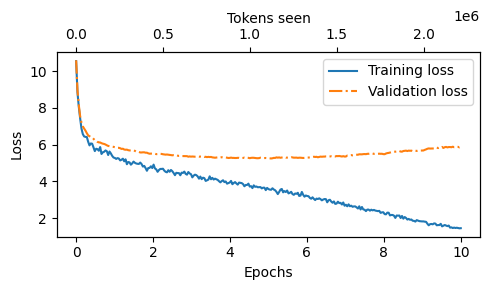

In [115]:
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator


def plot_losses(epochs_seen, tokens_seen, train_losses, val_losses):
    fig, ax1 = plt.subplots(figsize=(5, 3))

    # Plot training and validation loss against epochs
    ax1.plot(epochs_seen, train_losses, label="Training loss")
    ax1.plot(epochs_seen, val_losses, linestyle="-.", label="Validation loss")
    ax1.set_xlabel("Epochs")
    ax1.set_ylabel("Loss")
    ax1.legend(loc="upper right")
    ax1.xaxis.set_major_locator(MaxNLocator(integer=True))  # only show integer labels on x-axis

    # Create a second x-axis for tokens seen
    ax2 = ax1.twiny()  # Create a second x-axis that shares the same y-axis
    ax2.plot(tokens_seen, train_losses, alpha=0)  # Invisible plot for aligning ticks
    ax2.set_xlabel("Tokens seen")

    fig.tight_layout()  # Adjust layout to make room
    plt.savefig("loss-plot.pdf")
    plt.show()

epochs_tensor = torch.linspace(0, num_epochs, len(train_losses))
plot_losses(epochs_tensor, track_tokens_seen, train_losses, val_losses)